# Ground truth

Three different ground truths were prepared by three different people and then compared to increase the reliability of the ground truth.

In [1]:
%matplotlib inline

import hyperspy as hs
import pyxem as px
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from skimage import restoration
from matplotlib.colors import LogNorm

from numpy import log10

from scipy.ndimage import binary_fill_holes, label
from scipy import ndimage as ndi
from scipy.ndimage import gaussian_filter

from skimage.feature import peak_local_max
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from skimage.measure import label, regionprops
from skimage.segmentation import watershed
from skimage.filters import sobel, threshold_triangle, threshold_li

## Define cmap

In [2]:
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap

color_names = ['linen', 'darkorange', 'dodgerblue', 'forestgreen']
colors = [to_rgba(c) for c in color_names]

cmap = LinearSegmentedColormap.from_list('gt_cmap', colors, N=len(color_names))

## Load dataset

In [3]:
signal = hs.io.load('Data/datasetA_preprocessed.hspy')
DP_scale = signal.axes_manager[2].scale

In [4]:
output_directory = r'Data\Outputs'

## Create ground truths

### Ground truth #1

In this approach, a virtual dark-field (VDF) image is created per precipitate phase electron diffraction pattern.
vdf_phase_x refers to the VDFs for the two edge on configurations of T1 and $\theta'$, while vdf_theta_face_on refers to the VDF from $\theta'$ viewed face on.

#### Step 1: Create VDFs based on one reflection per precipitate phase

In [5]:
vdf_T1_1 = signal.get_integrated_intensity(hs.roi.CircleROI(cx=-0.12852, cy=0.46172, r=0.02856, r_inner=0))

vdf_T1_2 = signal.get_integrated_intensity(hs.roi.CircleROI(cx=0.44268, cy=0.09996, r=0.02856, r_inner=0))

vdf_theta1 = signal.get_integrated_intensity(hs.roi.CircleROI(cx=0.13804, cy=-0.2618, r=0.02856, r_inner=0))

vdf_theta2 = signal.get_integrated_intensity(hs.roi.CircleROI(cx=0.00476, cy=0.27132, r=0.02856, r_inner=0))

vdf_theta_faceon = signal.get_integrated_intensity(hs.roi.CircleROI(cx=0.34748, cy=0.08092, r=0.0476, r_inner=0))

#### Step 2: Threshold each VDF

$\theta'$ edge on. As this phase has intense reflections, li- and triangle thresholding was deemed sufficient for creating the binary VDFs for this phase.

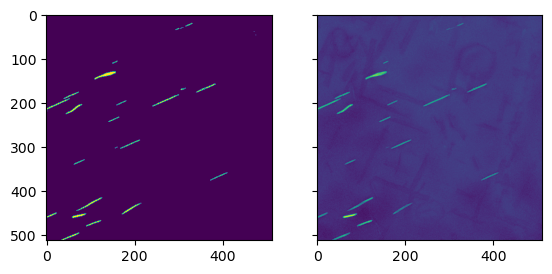

In [6]:
vdf_theta1_bin = vdf_theta1.data > threshold_triangle(vdf_theta1.data)
fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].imshow(vdf_theta1_bin)
ax[1].imshow(vdf_theta1, norm=LogNorm())

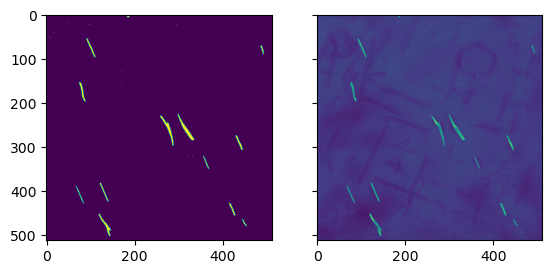

In [7]:
vdf_theta2_bin = vdf_theta2.data > threshold_triangle(vdf_theta2.data)
fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].imshow(vdf_theta2_bin)
ax[1].imshow(vdf_theta2, norm=LogNorm())

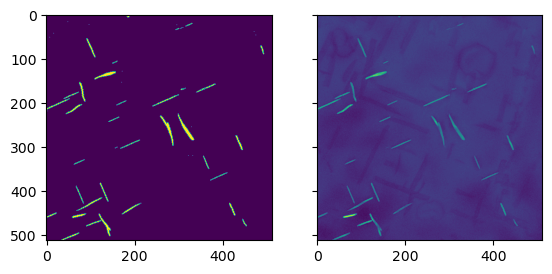

In [8]:
vdf_theta_bin = vdf_theta1_bin + vdf_theta2_bin
fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].imshow(vdf_theta_bin)
ax[1].imshow(vdf_theta1 + vdf_theta2, norm=LogNorm())

$\theta'$ face on. As this phase has weak refelctions, watershed segmentation was used for the creation of the binary VDFs for this phase.

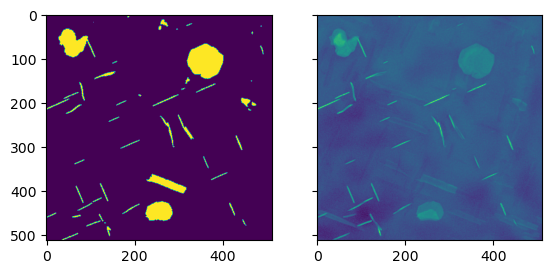

In [9]:
markers = np.zeros_like(vdf_theta_faceon)
markers[vdf_theta_faceon < 0.05] = 1
markers[vdf_theta_faceon > 0.079] = 2

elevation_map = sobel(vdf_theta_faceon.data)

segmentation = watershed(elevation_map, markers)
segmentation = ndi.binary_fill_holes(segmentation-1)
vdf_theta_faceon_bin = segmentation > 0

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].imshow(vdf_theta_faceon_bin)
ax[1].imshow(vdf_theta_faceon, norm=LogNorm())

T1 edge on. As this phase has weak reflections, watershed regmentation was used for the creation of the binary VDFs for this phase.

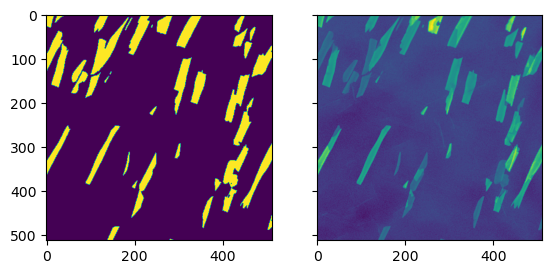

In [10]:
markers = np.zeros_like(vdf_T1_1)
markers[vdf_T1_1 < 0.012] = 1
markers[vdf_T1_1 > 0.02] = 2

elevation_map = sobel(vdf_T1_1.data)
segmentation = watershed(elevation_map, markers)
vdf_T1_1_bin = segmentation > 1
fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].imshow(vdf_T1_1_bin)
ax[1].imshow(vdf_T1_1, norm=LogNorm())

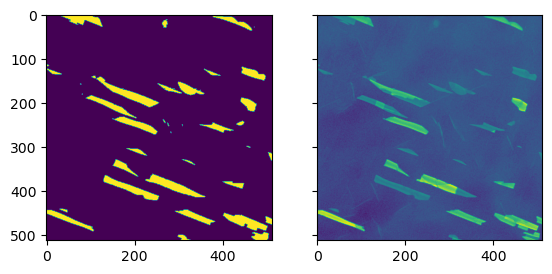

In [11]:
markers = np.zeros_like(vdf_T1_2)
markers[vdf_T1_2 < 0.014] = 1
markers[vdf_T1_2 > 0.02] = 2

elevation_map = sobel(vdf_T1_2.data)
segmentation = watershed(elevation_map, markers)
segmentation = ndi.binary_fill_holes(segmentation-1)
vdf_T1_2_bin = segmentation > 0

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].imshow(vdf_T1_2_bin)
ax[1].imshow(vdf_T1_2, norm=LogNorm())

In [12]:
vdf_T1_bin = vdf_T1_2_bin + vdf_T1_1_bin

#### Step 3: Remove unwanted pixels

$\theta'$

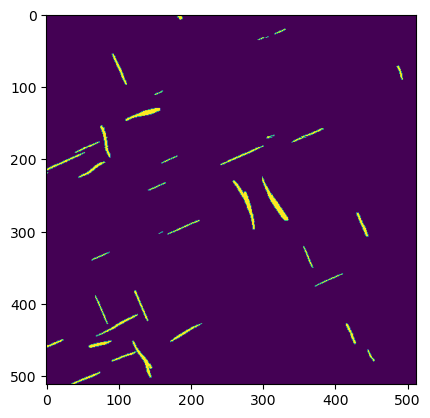

In [13]:
from skimage.measure import label, regionprops

theta_labeled = label(vdf_theta_bin)
props = regionprops(theta_labeled)
for i in range(len(props)):
    if props[i].area <= 3:
        for x_coord in props[i].coords[:,0]:
            for y_coord in props[i].coords[:,1]:
                vdf_theta_bin[x_coord, y_coord] = 0
plt.imshow(vdf_theta_bin)

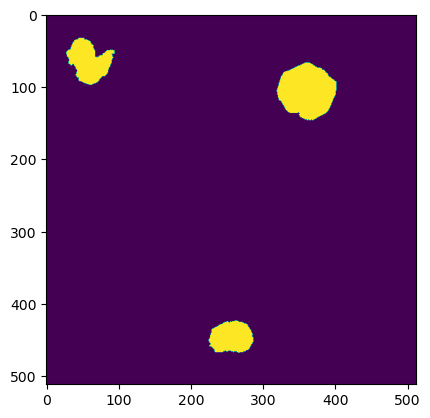

In [14]:
vdf_theta_faceon_labeled = label(vdf_theta_faceon_bin)
props = regionprops(vdf_theta_faceon_labeled)
for i in range(len(props)):
    if props[i].area <= 2000:
        for x_coord in props[i].coords[:,0]:
            for y_coord in props[i].coords[:,1]:
                vdf_theta_faceon_bin[x_coord, y_coord] = 0


vdf_theta_faceon_bin[np.argwhere(np.logical_and(vdf_theta_faceon_bin, vdf_theta_bin))[:,0], np.argwhere(np.logical_and(vdf_theta_faceon_bin, vdf_theta_bin))[:,1]] = False

vdf_theta_faceon_labeled = label(vdf_theta_faceon_bin)
props = regionprops(vdf_theta_faceon_labeled)
for i in range(len(props)):
    if props[i].area <= 2000:
        for x_coord in props[i].coords[:,0]:
            for y_coord in props[i].coords[:,1]:
                vdf_theta_faceon_bin[x_coord, y_coord] = 0


plt.imshow(vdf_theta_faceon_bin)

#### Create the ground truth image

Some of the precipitate phases are overlapping. A simple approach was chosen to overcome this challenge. Here, $\theta'$ edge on are prioritized over T1 edge on which is prioritized over $\theta'$ face on.

In [15]:
###### 
# Theta edge on is prioritised over T1. T1 is prioritised over theta face on #

vdf_T1_bin[np.argwhere(np.logical_and(vdf_T1_bin, vdf_theta_bin))[:,0], np.argwhere(np.logical_and(vdf_T1_bin, vdf_theta_bin))[:,1]] = False
vdf_theta_faceon_bin[np.argwhere(np.logical_and(vdf_T1_bin, vdf_theta_faceon_bin))[:,0], np.argwhere(np.logical_and(vdf_T1_bin, vdf_theta_faceon_bin))[:,1]] = False


vdf_T1_bin3 = np.zeros_like(vdf_T1_bin, dtype='int')
vdf_T1_bin3[vdf_T1_bin > 0] = 3

vdf_theta_bin_faceon2 = np.zeros_like(vdf_theta_faceon_bin, dtype='int')
vdf_theta_bin_faceon2[vdf_theta_faceon_bin > 0] = 2

vdf_theta_bin1 = np.zeros_like(vdf_theta_bin, dtype='int')
vdf_theta_bin1[vdf_theta_bin > 0] = 1

ground_truth_1 = vdf_T1_bin3 + vdf_theta_bin_faceon2 + vdf_theta_bin1
ground_truth_1 = hs.signals.BaseSignal(ground_truth_1)

#### Plot:

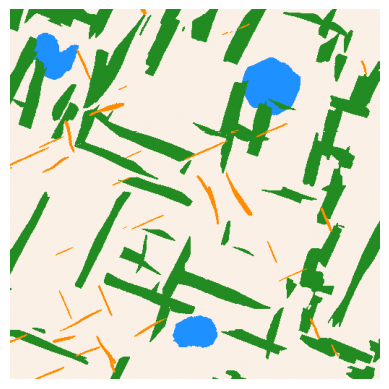

In [16]:
img_flatten = ground_truth_1.data.flatten()
image = np.zeros((512*512,4))
for i in range(len(color_names)):
    mask = img_flatten == i
    image[mask] = colors[i]
image = image.reshape((512,512,4))
fig,ax = plt.subplots()
ax.axis('off')
ax.imshow(image, cmap=cmap)
file_name = '/ground_truth_1.png'
plt.savefig(output_directory + file_name, transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)

### Ground truth #2

In [17]:
shift = 1/4096
signal_log = log10(signal.data+shift) - log10(shift)
signal_log = px.signals.ElectronDiffraction2D(signal_log)
scale = 1
signal_log.set_diffraction_calibration(scale)

In [18]:
signal_log.data = signal_log.data/np.max(signal_log.data)*4096
signal_log.change_dtype('uint32')

#### Create binary image of $\theta'$ edge on:

Create a VDF of the $\theta'$ edge on precipitates that point to the top right. Then threshold that VDF image and create a binary mask. 

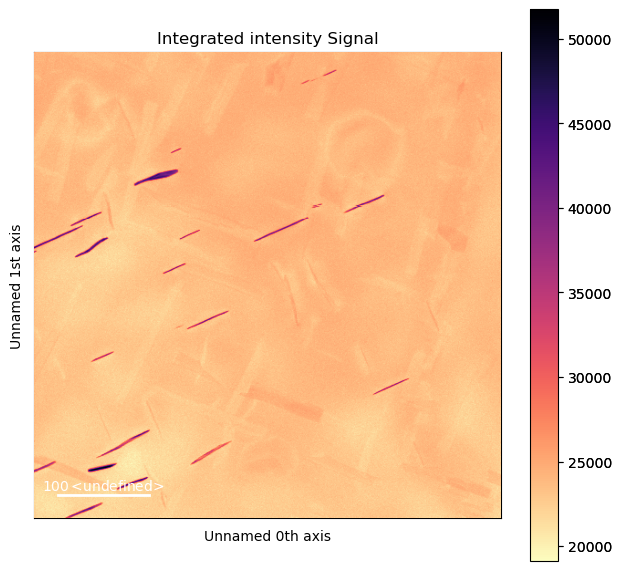

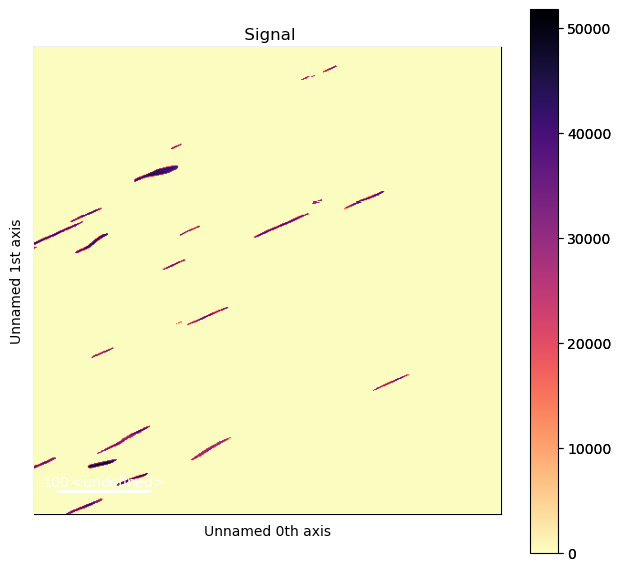

In [19]:
roi = hs.roi.CircleROI(cx=7, cy=-15, r=2.5, r_inner=0)
righttop = signal_log.get_integrated_intensity(roi)
righttop.plot(cmap='magma_r')
righttop_mask = righttop.data.copy()
righttop_mask[righttop_mask<26600] = 0
hs.signals.BaseSignal(righttop_mask).plot(cmap='magma_r')
righttop_mask = righttop_mask.astype('bool')

Create a VDF of the $\theta'$ edge on precipitates that point to the top left. Then threshold that VDF image and create a binary mask. 

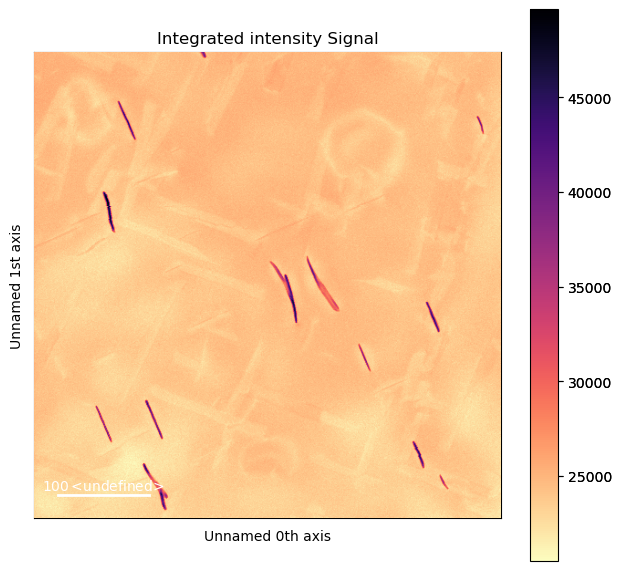

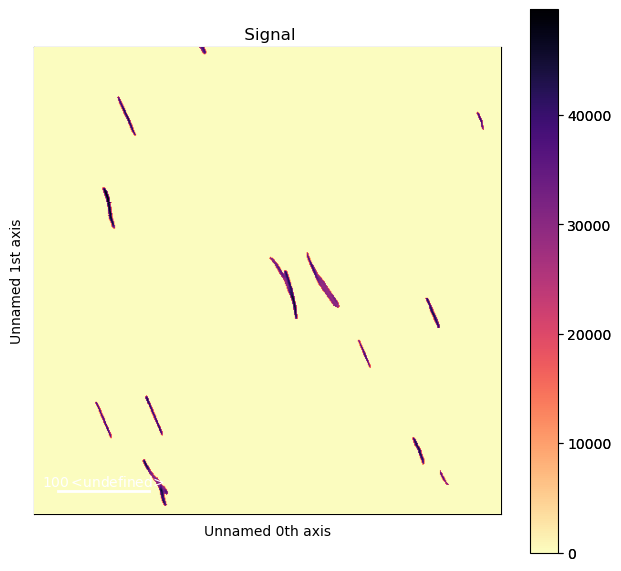

In [20]:
roi = hs.roi.CircleROI(cx=-14, cy=-8, r=2.5, r_inner=0)
lefttop = signal_log.get_integrated_intensity(roi)
lefttop.plot(cmap='magma_r')
lefttop_mask = lefttop.data.copy()
lefttop_mask[lefttop_mask<26600] = 0
hs.signals.BaseSignal(lefttop_mask).plot(cmap='magma_r')
lefttop_mask = lefttop_mask.astype('bool')

Combine the masks to form the final binary mask for $\theta'$ edge on, and plot this mask. 

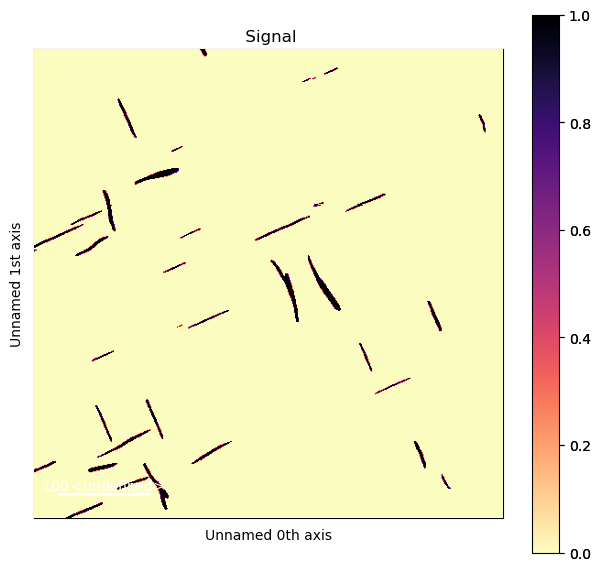

In [21]:
vdf_theta_bin = np.array(righttop_mask.copy() + lefttop_mask.copy(), dtype='bool')
hs.signals.BaseSignal(vdf_theta_bin).plot(cmap='magma_r')

#### Create binary image of T1:

The same approach was followed for the T1 precipitates. A VDF image was first created for those pointing to the top right, before a binary mask was created. 

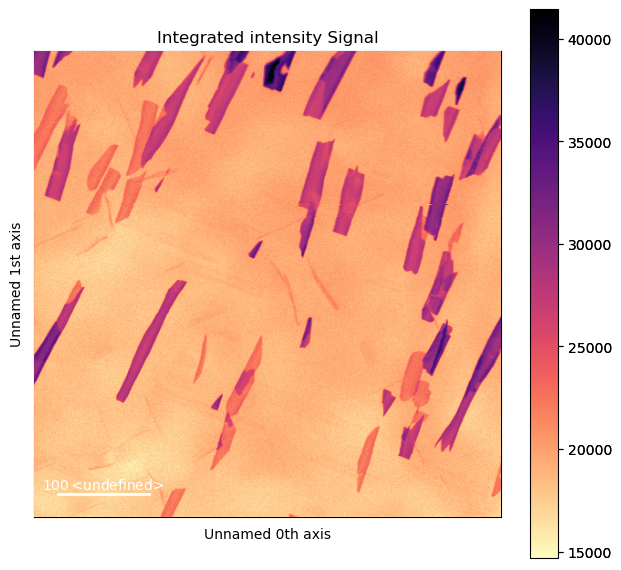

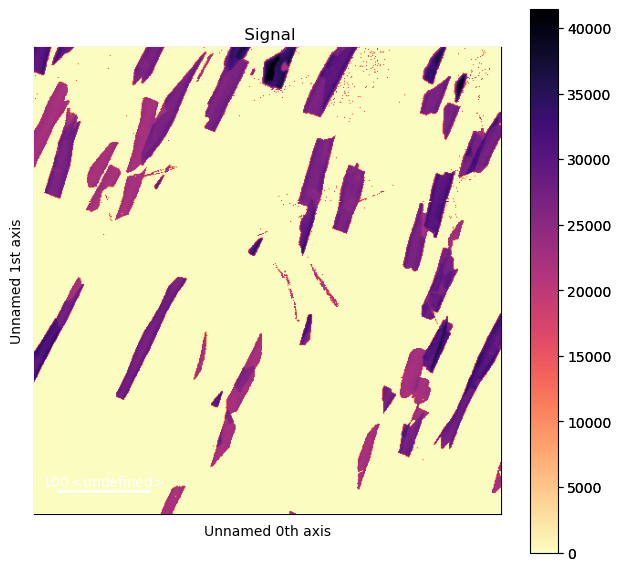

In [22]:
roi = hs.roi.CircleROI(cx=6, cy=-26, r=2.5, r_inner=0)
righttop = signal_log.get_integrated_intensity(roi)
righttop.plot(cmap='magma_r')
righttop_mask = righttop.data.copy()
righttop_mask[righttop_mask<20950] = 0 # 20715
hs.signals.BaseSignal(righttop_mask).plot(cmap='magma_r')

In the T1 mask, the pixels where the $\theta'$ edge on mask is True were set to False, in order to prioritise the $\theta'$ edge on in the case of overlap. 

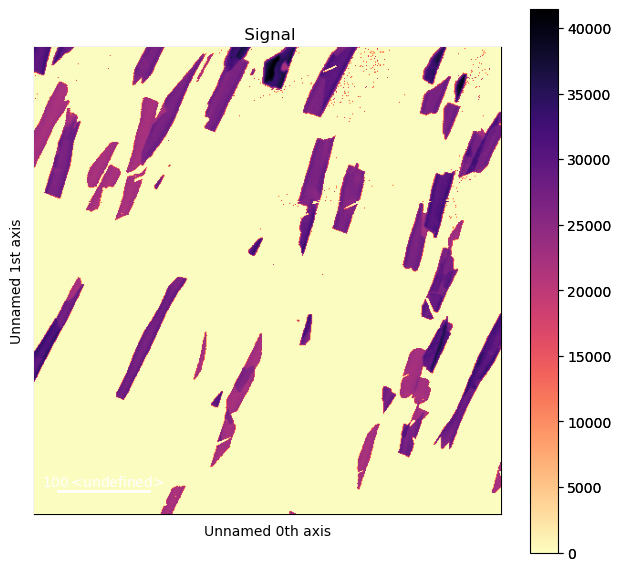

In [23]:
righttop_mask[vdf_theta_bin] = 0
hs.signals.BaseSignal(righttop_mask).plot(cmap='magma_r')

At this point the T1 mask contains noise, which we will remove by using the label functionality of scikit-image. This function gives the same labels to all pixels that are connected, so we can then delete those regions from the mask that correspond to labelled regions below a certain size, here 10. 

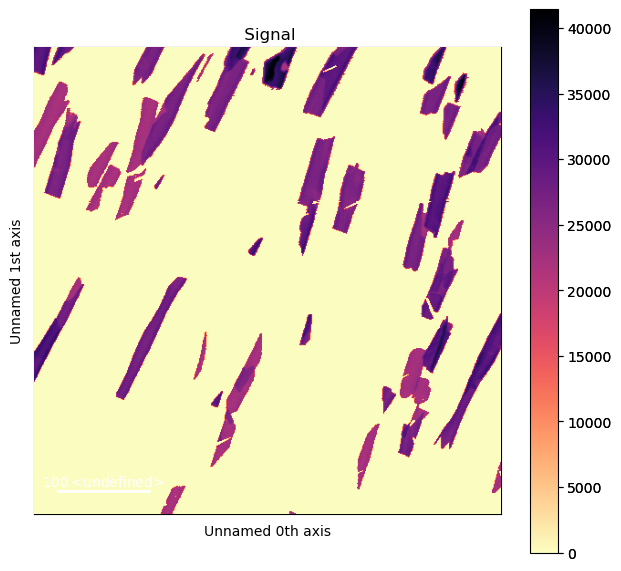

In [24]:
from scipy.ndimage import label

labs, _ = label(righttop_mask)
th = 10
for i in np.arange(1, np.max(labs)):
    if np.sum(labs[labs == i])/i < th:
        righttop_mask[labs == i] = 0
hs.signals.BaseSignal(righttop_mask).plot(cmap='magma_r')
righttop_mask = righttop_mask.astype('bool')

The same approach is then followed for the T1 precipitates that point to the top left. 

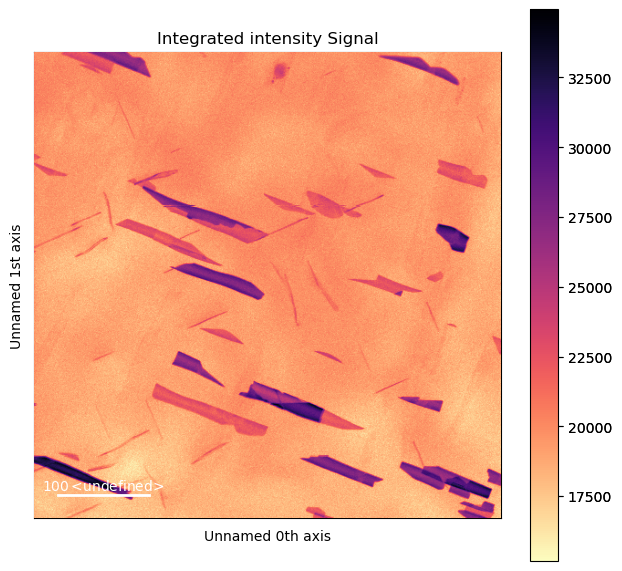

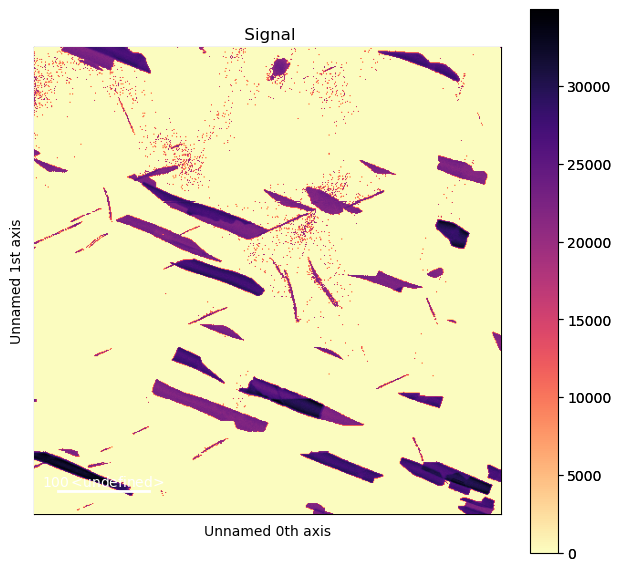

In [25]:
roi = hs.roi.CircleROI(cx=-24, cy=-9, r=2.5, r_inner=0)
lefttop = signal_log.get_integrated_intensity(roi)
lefttop.plot(cmap='magma_r')
lefttop_mask = lefttop.data.copy()
lefttop_mask[lefttop_mask<20610] = 0
hs.signals.BaseSignal(lefttop_mask).plot(cmap='magma_r')

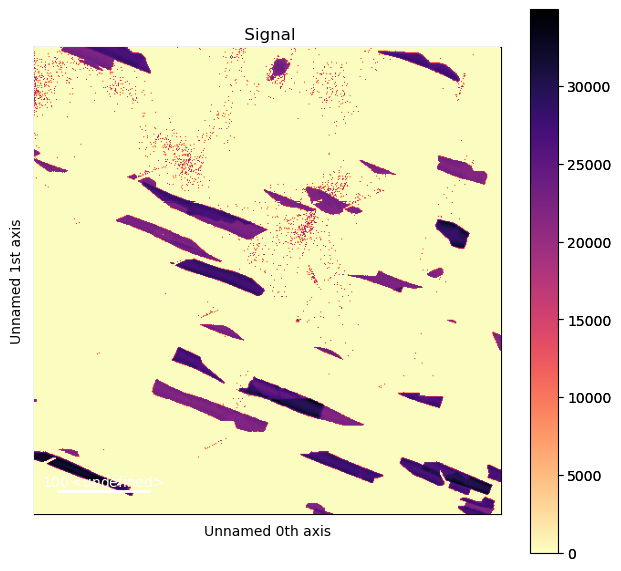

In [26]:
lefttop_mask[vdf_theta_bin] = 0
hs.signals.BaseSignal(lefttop_mask).plot(cmap='magma_r')

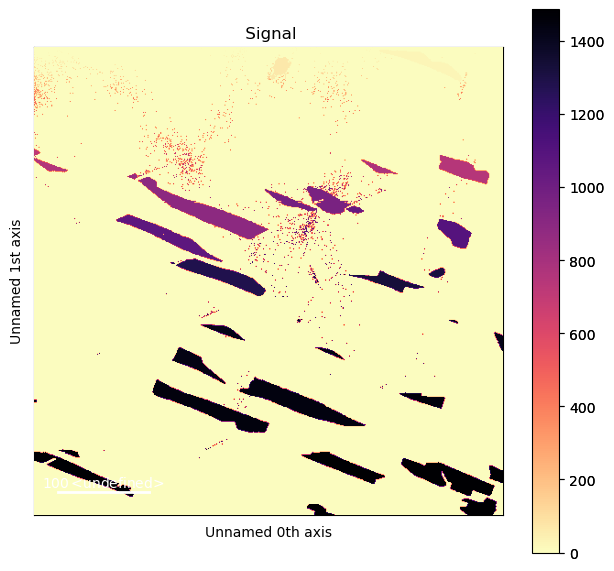

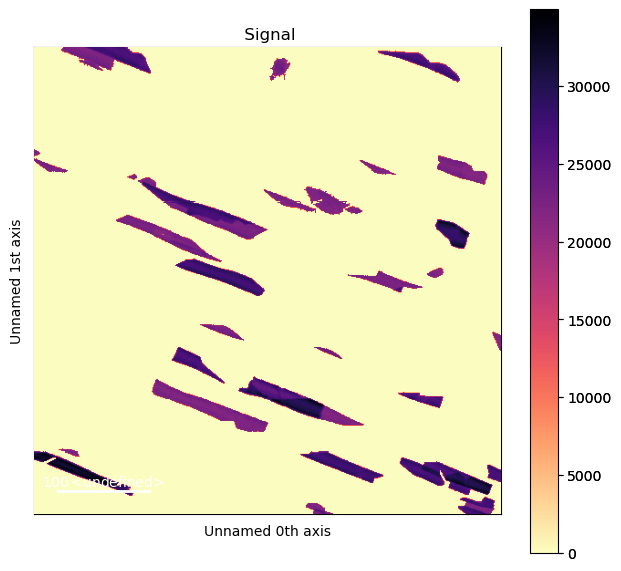

In [27]:
labs, _ = label(lefttop_mask)
hs.signals.BaseSignal(labs).plot(cmap='magma_r')
th = 30
for i in np.arange(1, np.max(labs)):
    if np.sum(labs[labs == i])/i < th:
        lefttop_mask[labs == i] = 0
hs.signals.BaseSignal(lefttop_mask).plot(cmap='magma_r')
lefttop_mask = lefttop_mask.astype('bool')

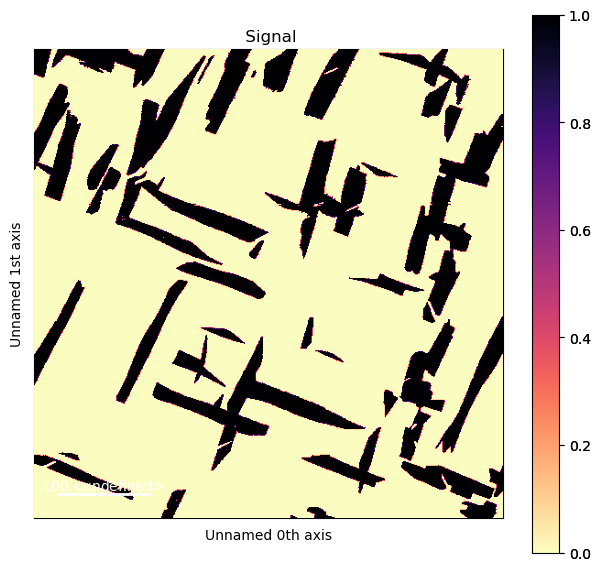

In [28]:
vdf_T1_bin = np.array(righttop_mask.copy() + lefttop_mask.copy(), dtype='bool')
hs.signals.BaseSignal(vdf_T1_bin).plot(cmap='magma_r')

#### Create binary image of $\theta'$ viewed face on:

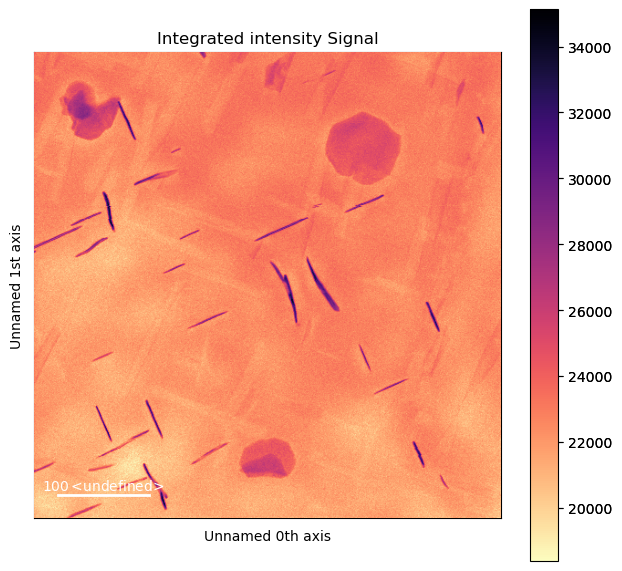

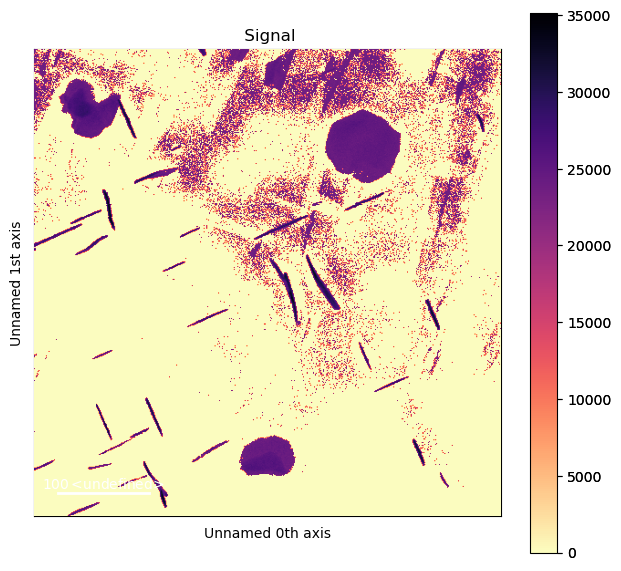

In [29]:
roi = hs.roi.CircleROI(cx=3, cy=-19, r=2.5, r_inner=0.5)
blobs = signal_log.get_integrated_intensity(roi)
blobs.plot(cmap='magma_r')
blobs_mask = blobs.data.copy()
blobs_mask[blobs_mask<23200] = 0
hs.signals.BaseSignal(blobs_mask).plot(cmap='magma_r')

The mask made from the VDF image contains a lot of noise and $\theta'$ edge on precipitates. To remove the noise and make the intensities even within the $\theta'$ face on precipitates, watershed image segmentation is used. 

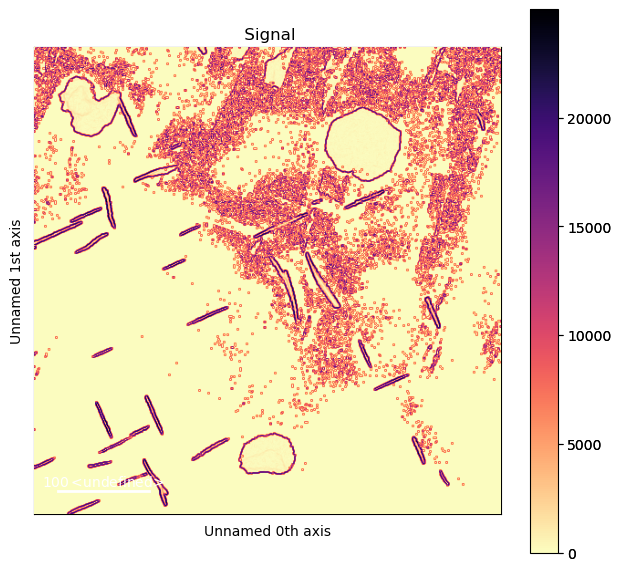

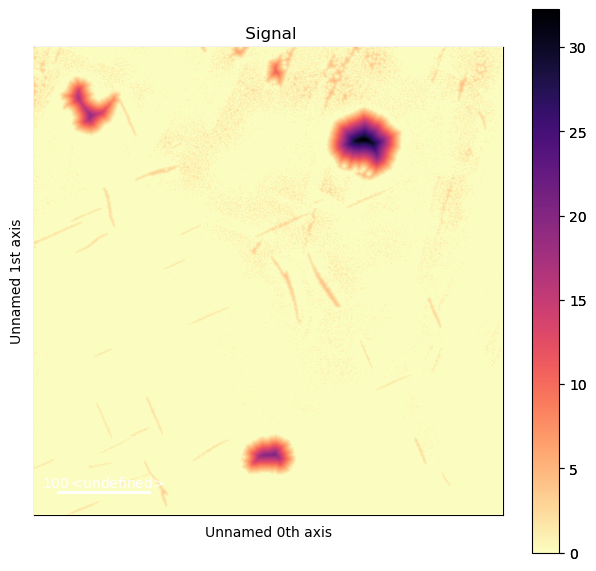

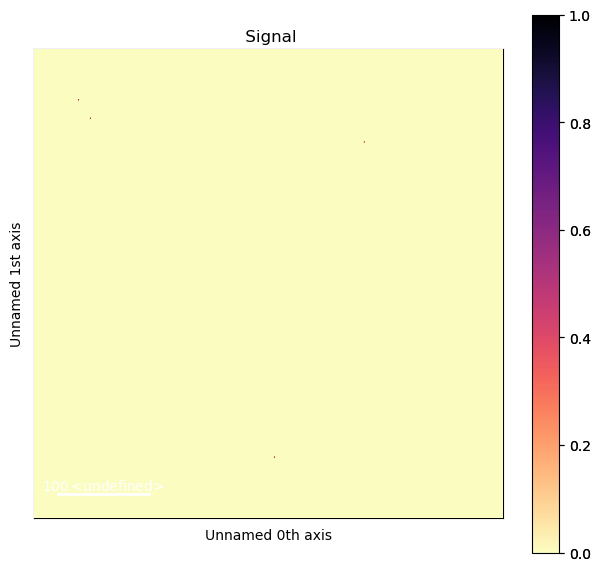

In [30]:
from scipy.ndimage import distance_transform_edt
blobs_mask_sobel = sobel(blobs_mask)
hs.signals.BaseSignal(blobs_mask_sobel).plot(cmap='magma_r')
dists = distance_transform_edt(blobs_mask)
hs.signals.BaseSignal(dists).plot(cmap='magma_r')
peaks = peak_local_max(dists, min_distance = 10, exclude_border = 1, threshold_abs = 12)
peaks_mask = np.zeros_like(blobs_mask)
peaks_mask[tuple(peaks.T)] = 1
hs.signals.BaseSignal(peaks_mask).plot(cmap='magma_r')

Perform the watershed image segmentation and then fill the holes within the three precipitate masks. 

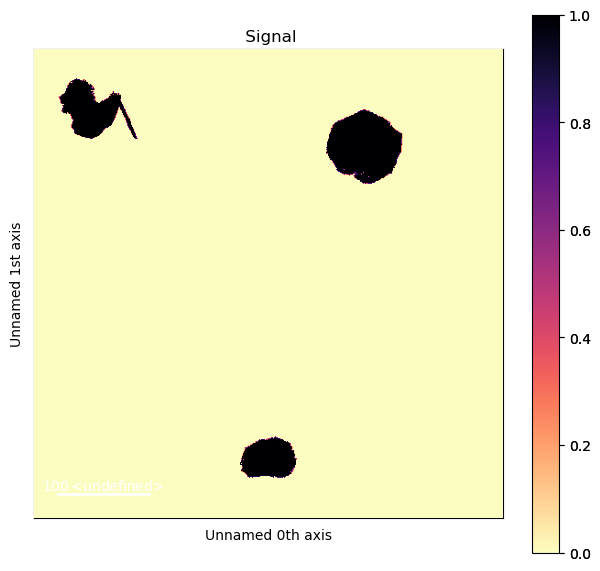

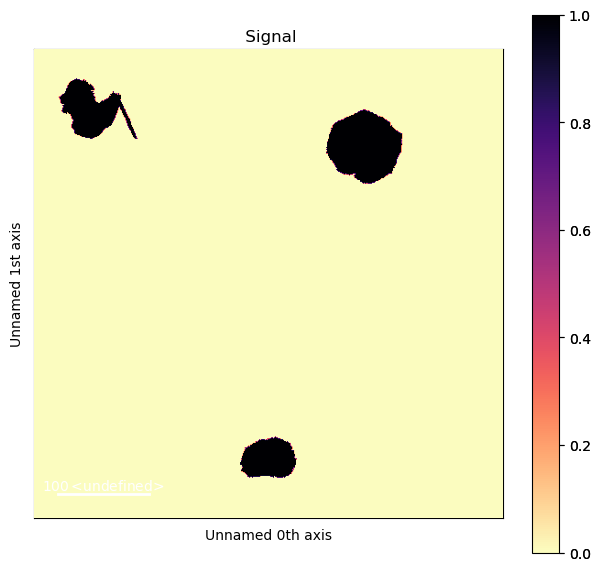

In [31]:
seg = watershed(image=blobs_mask_sobel, markers = peaks_mask, mask=blobs_mask)
hs.signals.BaseSignal(seg).plot(cmap='magma_r')
seg_fill = binary_fill_holes(seg)
hs.signals.BaseSignal(seg_fill).plot(cmap='magma_r')

We have picked out the thre precipitates. However, there is one $\theta'$ edge on precipitate that is connected to the left top $\theta'$ face on precipitate. In order to remove this one, we manually remove the incorrectly labeled pixels in the border. Thereafter, we use the label function to remove this precipiate. 

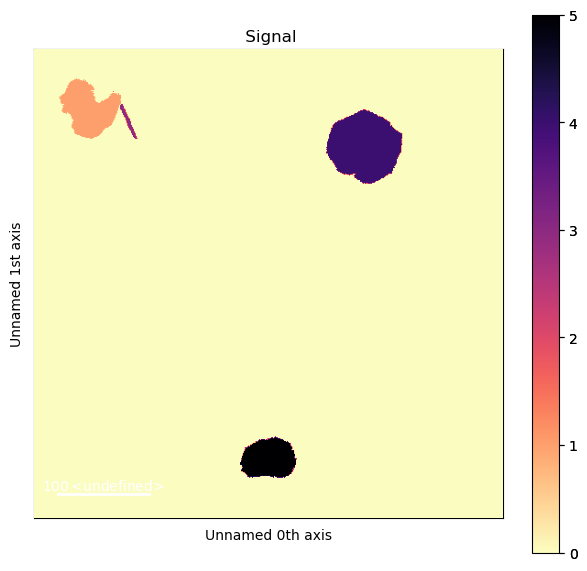

In [32]:
seg_fill[58, 95] = 0
seg_fill[59, 95] = 0
seg_fill[60, 94] = 0
seg_fill[61, 93] = 0
seg_fill[62, 93] = 0
seg_fill[47, 86] = 0
seg_fill[46, 87] = 0
seg_fill[46, 88] = 0
labels, num = label(seg_fill)
hs.signals.BaseSignal(labels).plot(cmap='magma_r')

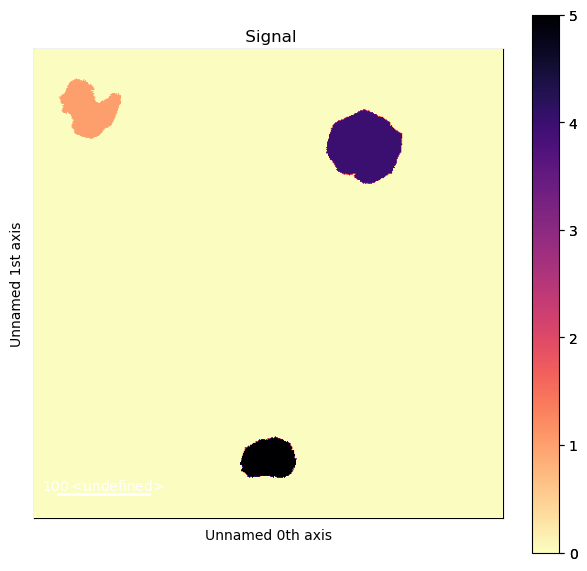

In [33]:
labels[labels == 2] = 0
labels[labels == 3] = 0
hs.signals.BaseSignal(labels).plot(cmap='magma_r')

In [34]:
vdf_theta_faceon_bin = np.array(labels, dtype='bool')

In [35]:
# NB!! The needles are prioritized over plates that are prioritized over blobs"
ground_truth_2 = np.zeros_like(blobs, dtype='int32')
ground_truth_2[vdf_theta_faceon_bin] = 2
ground_truth_2[vdf_T1_bin] = 3
ground_truth_2[vdf_theta_bin] = 1
ground_truth_2 = hs.signals.BaseSignal(ground_truth_2)

Correct some pixels manually.

In [36]:
ground_truth_2.data[73, 40] = 3 #(from 0 to 3)
ground_truth_2.data[182, 96] = 3 #(from 0 to 3)
ground_truth_2.data[186, 96] = 3 #(from 0 to 3)
ground_truth_2.data[185, 98] = 3 #(from 0 to 3)
ground_truth_2.data[205, 141] = 3 #(from 0 to 3)
ground_truth_2.data[170, 288] = 3 #(from 0 to 3)
ground_truth_2.data[84, 510] = 3 #(from 0 to 3)
ground_truth_2.data[84, 511] = 3 #(from 0 to 3)
ground_truth_2.data[411, 219] = 3 #(from 0 to 3)
ground_truth_2.data[412, 219] = 3 #(from 0 to 3)
ground_truth_2.data[412, 219] = 3 #(from 0 to 3)
ground_truth_2.data[492, 155] = 3 #(from 0 to 3)

#### Plot

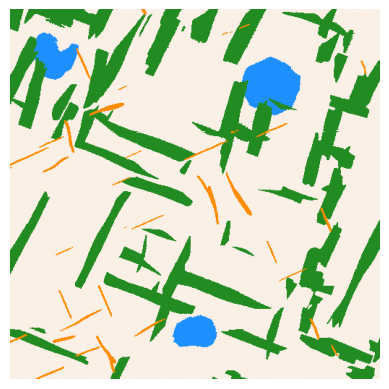

In [37]:
img_flatten = ground_truth_2.data.flatten()
image = np.zeros((512*512,4))
for i in range(len(color_names)):
    mask = img_flatten == i
    image[mask] = colors[i]
image = image.reshape((512,512,4))
fig,ax = plt.subplots()
ax.axis('off')
ax.imshow(image, cmap=cmap)
file_name = '/ground_truth_2.png'
plt.savefig(output_directory + file_name, transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)

### Ground truth #3

#### Make Precipitate object

In [38]:
from scipy.ndimage import label
import copy

#Creating empty dataset for variables in Precipitates() and also combined ground truth map eventually
empty_vdf = signal.get_integrated_intensity(hs.roi.CircleROI(cx=0, cy=0, r=0.5)).data.copy()
empty_vdf[empty_vdf > 0] = 0 

class Precipitate():
    name = ""
    th = 0
    roi = hs.roi.CircleROI(cx=0, cy=0, r=0, r_inner=0)
    roi2 = hs.roi.CircleROI(cx=0, cy=0, r=0, r_inner=0)
    label_th = 0
    vdf = empty_vdf.copy()
    vdf_mask = empty_vdf.copy()
    label, _ = label(vdf_mask)

    def __init__(self, name, th, label_th, roi):
        self.name = name
        self.th = th
        self.roi = roi
        self.label_th = label_th

def make_precip(name, th, label_th, roi):
    precipitate = Precipitate(name, th, label_th, roi)
    return precipitate
def make_precip2(name, th, label_th, roi, roi2):
    precipitate = Precipitate(name, th, label_th, roi)
    precipitate.roi2 = roi2
    return precipitate

In [39]:
#In plane theta'. Used two reflections for better signal 
roi_thetaPrimes = hs.roi.CircleROI(cx=-0.114238, cy=0.323675, r=0.0475943, r_inner=0)
roi_thetaPrimes2 = hs.roi.CircleROI(cx=0.323675, cy=0.0761587, r=0.0475943, r_inner=0)

#fat horizontals (T1)
roi_h = hs.roi.CircleROI(cx=-0.47124, cy=-0.14756, r=0.02856, r_inner=0)

#fat verticals (T1)
roi_v = hs.roi.CircleROI(cx=0.119, cy=-0.47124, r=0.02856, r_inner=0)

#left angled (thetaPrime, (200)_[010])
roi_la = hs.roi.CircleROI(cx=0.2142, cy=0.13804, r=0.0476, r_inner=0)

#right angled (thetaPrime, (020)_[100])
roi_ra = hs.roi.CircleROI(cx=0.13328, cy=-0.2856, r=0.0476, r_inner=0)

#--------------------------------------------------------------------------------------------#
#       inputs        |      name       |  th, | label_th,|      roi,     |     roi2         #
#--------------------------------------------------------------------------------------------#
Theta_3 =make_precip2("Theta, in-plane", 0.2,      782,    roi_thetaPrimes, roi_thetaPrimes2)#
T1_1    = Precipitate("T1, horizontal",  0.0138,    28,          roi_h )                     #
T1_2    = Precipitate("T1, vertical",    0.014,     28,          roi_v )                     #
Theta_1 = Precipitate("Theta, lefty",    0.12,       7,          roi_la)                     #
Theta_2 = Precipitate("Theta, righty",   0.17,       5,          roi_ra)                     #
#--------------------------------------------------------------------------------------------#

#list:
precips   = np.asarray([Theta_3, T1_1, T1_2, Theta_1, Theta_2])
numbering = np.asarray([   2,     3,     3,     1,       1   ])

In [40]:
for precip in precips:
    if (precip.name != "Theta, in-plane"): #in plane theta use two rois
        precip.vdf = signal.get_integrated_intensity(precip.roi)
    else:
        precip.vdf = signal.get_integrated_intensity(precip.roi) + signal.get_integrated_intensity(precip.roi2)

#### Create masks where you remove everything below certain threshold

In [41]:
for i, precip in enumerate(precips):
    if (precip.name != "Theta, in-plane"):
        vdf_mask = precip.vdf.data.copy()
        vdf_mask[vdf_mask < precip.th] = 0
        vdf_mask[vdf_mask > 0 ] = numbering[i]
        precip.vdf_mask = vdf_mask

    else:
        ### Need to remove edge on theta from in plane theta:
        vdf_mask_la = precips[3].vdf.data.copy()
        vdf_mask_la[vdf_mask_la < precips[3].th] = 0 # 3= left angle theta needles (see parameters for precips)
        vdf_mask_la[vdf_mask_la > 0] = 1

        vdf_mask_ra = precips[4].vdf.data.copy()
        vdf_mask_ra[vdf_mask_ra < precips[4].th] = 0 # 4 = righ angle theta needles
        vdf_mask_ra[vdf_mask_ra > 0] = 1

        #Adding unwanted thetas to one mask and setting any potential 2 = 1
        combined_mask = vdf_mask_la + vdf_mask_ra
        combined_mask[combined_mask > 0] = 1 # All needle pix should be 1
        #### ----- ###

        vdf_mask = precip.vdf.data.copy()
        vdf_mask[vdf_mask < precip.th] = 0
        vdf_mask[vdf_mask > 0 ] = numbering[i]

        # Removing other oriientations from map
        vdf_mask[vdf_mask == combined_mask*2] = 0
        precip.vdf_mask = vdf_mask

#### Use label from scipy to remove noise

In [42]:
from scipy.ndimage import label

for precip in precips:
    # Labels groups of pixels by size
    precip.label = label(precip.vdf_mask)[0]
    for i in np.arange(1, np.max(precip.label)):
        # Everything below label_th size concidered noise and removed:
        if np.sum(precip.label[precip.label == i])/i < precip.label_th: 
            precip.vdf_mask[precip.label == i] = 0

#### Now combine all masks to ground truth

In [43]:
ground_truth_3 = empty_vdf.copy()

for i, precip in enumerate(precips):
    precip = precip
    ground_truth_3[precip.vdf_mask == numbering[i]] = numbering[i]

#### Plot

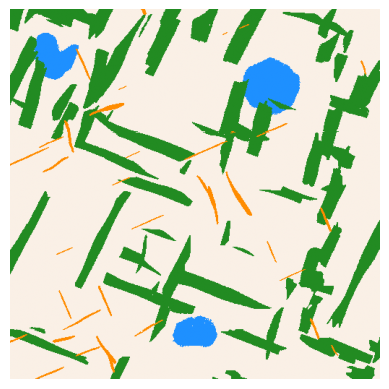

In [44]:
img_flatten = ground_truth_3.flatten()
image = np.zeros((512*512,4))
for i in range(len(color_names)):
    mask = img_flatten == i
    image[mask] = colors[i]
image = image.reshape((512,512,4))
fig,ax = plt.subplots()
ax.axis('off')
ax.imshow(image, cmap=cmap)
file_name = '/ground_truth_3.png'
plt.savefig(output_directory + file_name, transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)

ground_truth_3 = hs.signals.Signal2D(ground_truth_3)

### Save ground truths

In [45]:
ground_truth_1.axes_manager[0].scale = 4.63
ground_truth_1.axes_manager[1].scale = 4.63
ground_truth_1.axes_manager[0].units = 'nm'
ground_truth_1.axes_manager[1].units = 'nm'

ground_truth_2.axes_manager = ground_truth_1.axes_manager
ground_truth_3.axes_manager = ground_truth_1.axes_manager

In [46]:
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

ground_truth_1.save(output_directory + '/ground_truth_1.hspy')
ground_truth_2.save(output_directory + '/ground_truth_2.hspy')
ground_truth_3.save(output_directory + '/ground_truth_3.hspy')

### Load and compare the three different ground truths

The following ints are used for the four different precipitate phases in the ground truths: <br>
<ul>
    <li> Al: 0 </li>
    <li> $\theta'$ edge on: 1 </li>
    <li> $\theta'$ face on: 2 </li>
    <li> T1: 3 </li>
    <li> Not indexed: 4 </li>
</ul>

In [47]:
ground_truth_1 = hs.io.load(output_directory + '/ground_truth_1.hspy')
ground_truth_2 = hs.io.load(output_directory + '/ground_truth_2.hspy')
ground_truth_3 = hs.io.load(output_directory + '/ground_truth_3.hspy')

In [48]:
difference_12 = ground_truth_1.data - ground_truth_2.data
difference_13 = ground_truth_1.data - ground_truth_3.data
difference_23 = ground_truth_2.data - ground_truth_3.data

Text(0.5, 1.0, 'Difference 2 3')

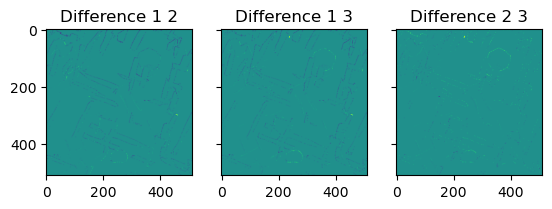

In [49]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True)
ax[0].imshow(difference_12)
ax[0].set_title('Difference 1 2')
ax[1].imshow(difference_13)
ax[1].set_title('Difference 1 3')
ax[2].imshow(difference_23)
ax[2].set_title('Difference 2 3')

### Prepare the final ground truth image

In [50]:
ground_truth = np.zeros_like(ground_truth_1.data)
for i in range(ground_truth_1.data.shape[0]):
    for j in range(ground_truth_1.data.shape[1]):
        if ground_truth_1.data[i,j] == ground_truth_2.data[i,j]: 
            ground_truth[i,j] = ground_truth_1.data[i,j]
        if ground_truth_1.data[i,j] == ground_truth_3.data[i,j]:
            ground_truth[i,j] = ground_truth_1.data[i,j]
        if ground_truth_2.data[i,j] == ground_truth_3.data[i,j]:
            ground_truth[i,j] = ground_truth_3.data[i,j]
        if ground_truth_1.data[i,j] != ground_truth_2.data[i,j] and ground_truth_1.data[i,j] != ground_truth_3.data[i,j] and ground_truth_2.data[i,j] != ground_truth_3.data[i,j]:
            ground_truth[i,j] = 4

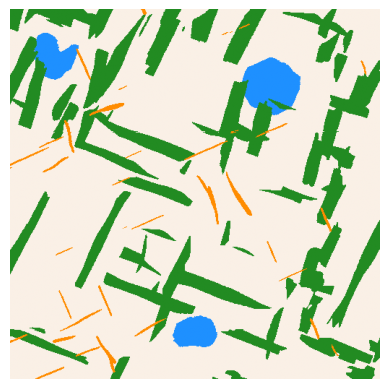

In [51]:
img_flatten = ground_truth.flatten()
image = np.zeros((512*512,4))
for i in range(len(color_names)):
    mask = img_flatten == i
    image[mask] = colors[i]
image = image.reshape((512,512,4))
fig,ax = plt.subplots()
ax.axis('off')
ax.imshow(image, cmap=cmap)
file_name = '/ground_truth.png'
plt.savefig(output_directory + file_name, transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [52]:
ground_truth = hs.signals.BaseSignal(ground_truth)
ground_truth.axes_manager = ground_truth_1.axes_manager.deepcopy()

In [53]:
ground_truth.save(output_directory + '/ground_truth.hspy')